Initial accuracy: 0.7835
Accuracy after GridSearch (old clf): 0.7835
Best parameters: {'metric': 'manhattan', 'n_neighbors': np.int64(4), 'weights': 'distance'}


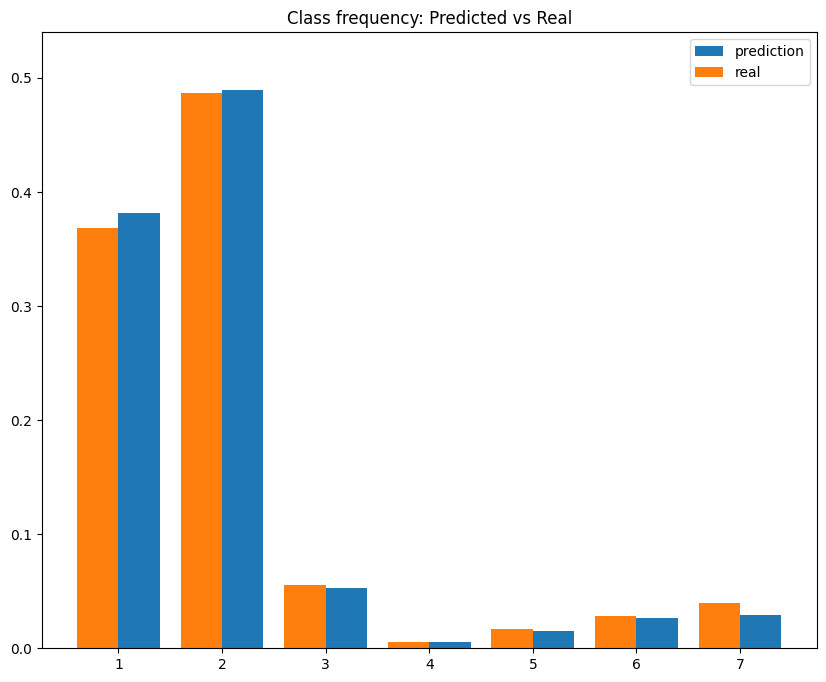

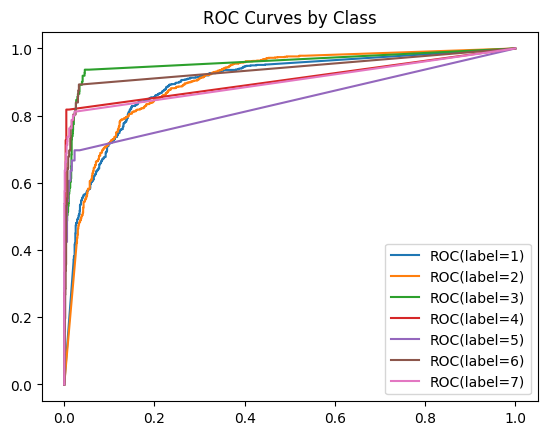

Macro averaged AUC-ROC: 0.9063452430548241
Weighted averaged AUC-ROC: 0.9040564360102934


In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Загрузка данных
url = 'https://drive.google.com/uc?export=download&id=1hkgqZ9Dx-3KT88y5ZB3iHhsHnkj2EIK0'
df = pd.read_csv(url)

# Делим на признаки и метки
labels = df[df.columns[-1]].values
feature_matrix = df[df.columns[:-1]].values

# Разбиваем на обучающую и тестовую выборки
train_feature_matrix, test_feature_matrix, train_labels, test_labels = train_test_split(
    feature_matrix, labels, test_size=0.2, random_state=42
)

# Базовая модель k-NN
clf = KNeighborsClassifier(n_neighbors=5, metric='l1', weights='distance')
clf.fit(train_feature_matrix, train_labels)
preds = clf.predict(test_feature_matrix)
print("Initial accuracy:", accuracy_score(test_labels, preds))

# Подбор гиперпараметров
params = {
    'n_neighbors': np.arange(1, 11),
    'metric': ['manhattan', 'euclidean'],
    'weights': ['uniform', 'distance'],
}
clf_grid = GridSearchCV(clf, params, cv=5, scoring='accuracy', n_jobs=-1)
clf_grid.fit(train_feature_matrix, train_labels)

# Предсказания после настройки
preds = clf.predict(test_feature_matrix)
print("Accuracy after GridSearch (old clf):", accuracy_score(test_labels, preds))

print("Best parameters:", clf_grid.best_params_)

# Обучение оптимальной модели
optimal_clf = KNeighborsClassifier(**clf_grid.best_params_)
optimal_clf.fit(train_feature_matrix, train_labels)
pred_prob = optimal_clf.predict_proba(test_feature_matrix)
preds = optimal_clf.predict(test_feature_matrix)

# Сравнение распределений вероятностей
unique, freq = np.unique(test_labels, return_counts=True)
freq = list(map(lambda x: x / len(test_labels), freq))
pred_freq = pred_prob.mean(axis=0)

plt.figure(figsize=(10, 8))
plt.bar(range(1, 8), pred_freq, width=0.4, align="edge", label='prediction')
plt.bar(range(1, 8), freq, width=-0.4, align="edge", label='real')
plt.ylim(0, 0.54)
plt.legend()
plt.title("Class frequency: Predicted vs Real")
plt.show()

# ROC-кривые и AUC-ROC
roc_scores = []
for i in range(7):
    roc = roc_curve(test_labels, pred_prob[:, i], pos_label=i+1)
    roc_scores.append(roc_auc_score(test_labels == i+1, pred_prob[:, i]))
    plt.plot(roc[0], roc[1], label=f'ROC(label={i+1})')

plt.legend()
plt.title("ROC Curves by Class")
plt.show()

# Усреднённые AUC-ROC
unique_labels, label_counts = np.unique(test_labels, return_counts=True)
weights = label_counts[np.argsort(unique_labels)] / label_counts.sum()
roc_scores = np.array(roc_scores)

macro = roc_scores.mean()
weighted = (roc_scores * weights).sum()

print('Macro averaged AUC-ROC:', macro)
print('Weighted averaged AUC-ROC:', weighted)